# DataCamp Certification Case Study

### Project Brief

You are on the data science team for Java June, a coffee company looking to expand its business into Ukraine. However, the pandemic has changed how people buy coffee. In some countries, the number of coffee shops offering delivery has increased by 240%. Understanding how the pandemic has affected the Ukrainian coffee market will be critical to success.

You have a dataset from Google businesses. It contains information about coffee shops in Ukraine. The marketing manager wants to identify the key coffee shop segments. They will use this to construct their marketing plan. In their current location, they split the market into five segments. The marketing manager wants to know how many segments are in this new market and their key features. 

You will need to present your findings in two formats:
- You must submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why. 
- You will then need to share your findings with the marking manager in a 10 minute presentation. The marketing manager has no data science background but is familiar with basic data related terminology. 

The data you will use for this analysis can be accessed here: `"data/coffee_shops.csv"`

## Getting started

### Principal steps

Since we are not interested in predicting any target variable, but are rather interested in understanding how we can subdivide the Ukrainian coffee shop market (number of segments and their key characteristics), we are dealing with a clustering problem. We will proceed as follows: 
1. First, we will make the small adjustments to the dataset necessary to proceed with the exploratory analysis. 
2. Then, through EDA, we will try to discover any patterns related to missing values, numeric and categorical variables. 
3. Based on what emerged from the exploratory analysis, we will be able to conduct the feature engineering phase and ...
4. ... implement the clustering models (we will try both K-Means and Hierarchical clustering) and try to understand how clusters are built. 
5. Finally, we will interpret the results obtained in light of the business requirements in order to obtain useful insights.

### Loading libraries

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import KMeans

### Importing the dataset, displaying its shape, summary statistics and head

In [52]:
df = pd.read_csv('data/coffee_shops.csv')

print(df.shape)
print(df.describe())
df.head()

(200, 9)
           Rating       Reviews
count  198.000000    198.000000
mean     4.663636    622.494949
std      0.221648   1400.898666
min      3.900000      3.000000
25%      4.600000     47.500000
50%      4.700000    271.500000
75%      4.800000    786.250000
max      5.000000  17937.000000


,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,NaN,NaN,NaN,NaN
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,NaN,True
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,NaN,NaN,NaN,True
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,NaN,NaN,True,True


### Checking data types and missing values

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           200 non-null    object 
 1   Place name       200 non-null    object 
 2   Place type       200 non-null    object 
 3   Rating           198 non-null    float64
 4   Reviews          198 non-null    float64
 5   Price            122 non-null    object 
 6   Delivery option  129 non-null    object 
 7   Dine in option   140 non-null    object 
 8   Takeout option   144 non-null    object 
dtypes: float64(2), object(7)
memory usage: 14.2+ KB


In [54]:
print('Unique values in "Rating": ', df['Rating'].unique())
print('Unique values in "Price": ', df['Price'].unique())
print('Unique values in "Delivery option": ', df['Delivery option'].unique())
print('Unique values in "Dine in option": ', df['Dine in option'].unique())
print('Unique values in "Takeout option": ', df['Takeout option'].unique())

Unique values in "Rating":  [4.6 5.  4.4 4.8 4.9 4.5 4.2 4.7 4.3 4.1 nan 4.  3.9]
Unique values in "Price":  [nan '$$' '$' '$$$']
Unique values in "Delivery option":  [nan False True]
Unique values in "Dine in option":  [nan True]
Unique values in "Takeout option":  [nan True]


#### Missing values in "Dine in option" and "Takeout option" features are not proper missing values since there are no "False" labels in them (differently from "Delivery option"). We can assume that missing values in those features actually indicate the "False" label so we can proceed fixing this issue before proceeding with our analysis.

### Fixing improper missing values in 'Dine in option' and 'Takeout option'

In [55]:
df['Dine in option'] = np.where(df['Dine in option'].isna(), False, True)
df['Takeout option'] = np.where(df['Takeout option'].isna(), False, True)

In [56]:
print(df['Dine in option'].unique())
print(df['Takeout option'].unique())

df.info()

[False  True]
[False  True]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           200 non-null    object 
 1   Place name       200 non-null    object 
 2   Place type       200 non-null    object 
 3   Rating           198 non-null    float64
 4   Reviews          198 non-null    float64
 5   Price            122 non-null    object 
 6   Delivery option  129 non-null    object 
 7   Dine in option   200 non-null    bool   
 8   Takeout option   200 non-null    bool   
dtypes: bool(2), float64(2), object(5)
memory usage: 11.5+ KB


#### We cannot fix the data type of the 'Delivery option' feature and transform it to boolean, otherwise missing values will be mismanaged and turned to 'True'.

### Replacing dollar signs in 'Price' column with 'Low', 'Medium' and 'High' (to avoid problems during the data visualization part)

In [57]:
df['Price'] = np.where(df['Price'] == '$', 'Low', df['Price'])
df['Price'] = np.where(df['Price'] == '$$', 'Medium', df['Price'])
df['Price'] = np.where(df['Price'] == '$$$', 'High', df['Price'])

df

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,NaN,NaN,False,False
1,Mariupol,Коферум,Cafe,5.0,24.0,Medium,False,False,True
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,NaN,NaN,False,True
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,Medium,False,True,True
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,NaN,NaN,True,True
...,...,...,...,...,...,...,...,...,...
195,Dnipro,Artist,Restaurant,4.6,963.0,High,NaN,True,True
196,Dnipro,Dream Cafe,Cafe,4.3,646.0,Medium,False,True,True
197,Dnipro,РУТА КАФЕ ПП КУЛІЧЕНКО К.І.,Cafe,4.6,16.0,Medium,False,True,True
198,Dnipro,Ob'yektna Kava,Coffee shop,4.7,599.0,Medium,NaN,True,True


## Exploratory Data Analysis (EDA)

### Missing values

#### Calculating the percentage of missing values for each feature

In [58]:
features_with_na = [feature for feature in df.columns if df[feature].isna().sum() > 1]

for feature in features_with_na:
    print('The "{}" variable has {}% of values missing'.format(feature, round(df[feature].isna().mean()*100, 2)))

The "Rating" variable has 1.0% of values missing
The "Reviews" variable has 1.0% of values missing
The "Price" variable has 39.0% of values missing
The "Delivery option" variable has 35.5% of values missing


#### Exploring potential relationships between the presence of missing values and other features

##### Regions

In [59]:
((1-df.groupby('Region', dropna=False).count()/20)*100)

,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
Region,,,,,,,,
Dnipro,0.0,0.0,5.0,5.0,40.0,50.0,0.0,0.0
Kharkiv,0.0,0.0,0.0,0.0,25.0,40.0,0.0,0.0
Kherson,0.0,0.0,5.0,5.0,40.0,15.0,0.0,0.0
Khrivoy Rog,0.0,0.0,0.0,0.0,35.0,25.0,0.0,0.0
Kiev,0.0,0.0,0.0,0.0,50.0,50.0,0.0,0.0
Lviv,0.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0
Mariupol,0.0,0.0,0.0,0.0,40.0,40.0,0.0,0.0
Odessa,0.0,0.0,0.0,0.0,60.0,55.0,0.0,0.0
Poltava,0.0,0.0,0.0,0.0,35.0,15.0,0.0,0.0


Tab.1: percentage of missing values for each feature by regions

Rating and Reviews: it seems there isn't any relationship between regions and missing values.

Price: Odessa, Kiev and Zaporozhye are the regions presenting a higher number of missing values.

Delivery option: Odessa, Kiev, Dnipro and Zaporozhye are the regions presenting a higher number of missing values.

##### In general, we can state that Odessa, Kiev and Zaporozhye are the regions with the least complete information. On the other hand, Lviv is the region with the most complete information. Let's continue our analysis and check if the presence of missing values really depends on the location region or if there are other factors affecting this dynamic

##### Place type

In [60]:
df.groupby('Place type')['Place name'].count().sort_values(ascending=False).head(4)

Place type
Coffee shop     97
Cafe            58
Espresso bar    20
Coffee store    11
Name: Place name, dtype: int64

As we could expect, Coffee shops, Cafes, Espresso bars and Coffee stores make 186 out of 200 shops considered (about 93% of the dataset). Therefore, we will consider only those type of places when analysing their relationships with the presence of missing values.

In [61]:
round((df.fillna(' ').groupby('Place type').count() - df.groupby('Place type', dropna=False).count())/(df.fillna(' ').groupby('Place type').count())*100, 2)

,Region,Place name,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
Place type,,,,,,,,
Appliance repair service,0.0,0.0,0.00,0.00,100.00,100.00,0.0,0.0
Cafe,0.0,0.0,1.72,1.72,29.31,32.76,0.0,0.0
Chocolate shop,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0
Coffee roasters,0.0,0.0,0.00,0.00,100.00,50.00,0.0,0.0
Coffee shop,0.0,0.0,1.03,1.03,35.05,31.96,0.0,0.0
Coffee stand,0.0,0.0,0.00,0.00,0.00,100.00,0.0,0.0
Coffee store,0.0,0.0,0.00,0.00,90.91,45.45,0.0,0.0
E-commerce service,0.0,0.0,0.00,0.00,100.00,100.00,0.0,0.0
Espresso bar,0.0,0.0,0.00,0.00,40.00,35.00,0.0,0.0


Tab.2: percentage of missing values for each feature by place types

Coffee shops present a percentage of missing values between 32 to 35%.
Cafes present a percentage of missing values between 29 to 33%.
Espresso bars present a percentage of missing values between 35 to 40%.
Coffee stores present a percentage of missing values between 45 to 91%.

##### Let's check the distribution of place types by regions

In [62]:
pd.crosstab(df['Region'], df['Place type'])

Place type,Appliance repair service,Cafe,Chocolate shop,Coffee roasters,Coffee shop,Coffee stand,Coffee store,E-commerce service,Espresso bar,European restaurant,Internet shop,Pastry shop,Restaurant,Store
Region,,,,,,,,,,,,,,
Dnipro,0,12,0,0,4,0,1,0,0,0,0,1,1,1
Kharkiv,0,1,0,0,14,0,2,0,3,0,0,0,0,0
Kherson,0,5,0,0,12,0,0,0,2,1,0,0,0,0
Khrivoy Rog,0,15,0,0,3,0,1,0,1,0,0,0,0,0
Kiev,0,4,0,0,8,0,2,1,5,0,0,0,0,0
Lviv,0,4,0,1,15,0,0,0,0,0,0,0,0,0
Mariupol,0,7,0,0,11,0,1,0,1,0,0,0,0,0
Odessa,0,0,0,1,14,0,1,0,2,0,0,1,0,1
Poltava,0,5,1,0,10,0,2,0,2,0,0,0,0,0


Tab.3: number of shops by regions and place types

##### Kiev and Zaporozhye are the regions having more espresso bars. Lviv is the only region having neither a coffe store nor an espresso bar.
#### In general, we can conclude that the presence of missing values depends more on the place type than on the region of location.

### Numerical variables

#### Rating

##### Distribution

<AxesSubplot:xlabel='Rating', ylabel='Density'>

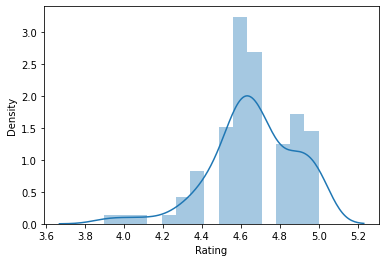

In [63]:
sns.distplot(df['Rating'], bins=15)

##### vs categorical features (from now on, for a correct visualization, we will group the shops that do not fall within the first 4 place types under the name of 'others')

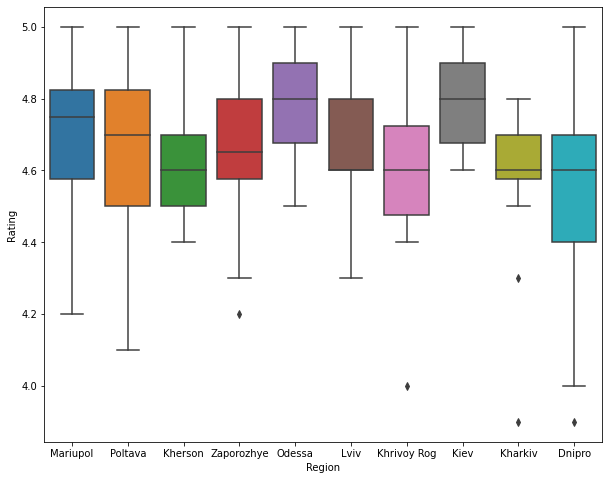

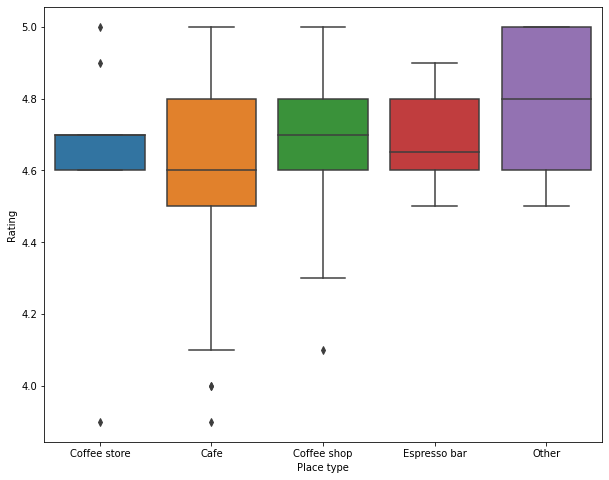

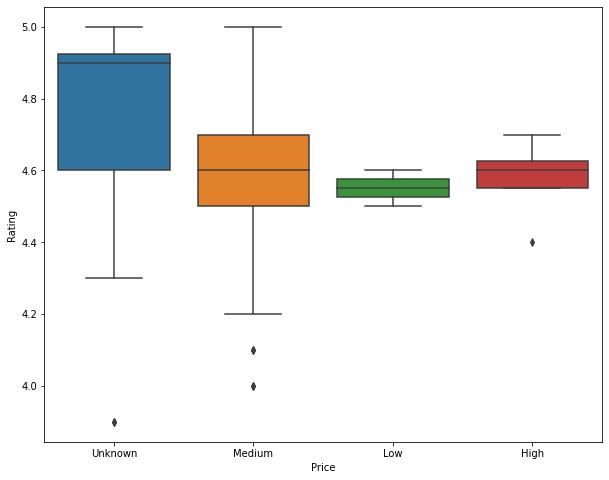

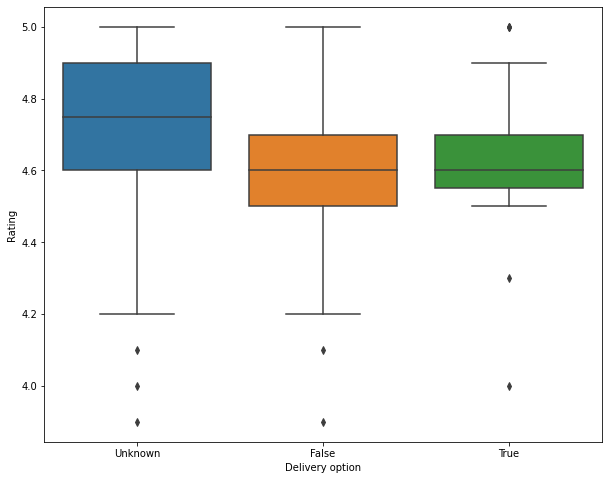

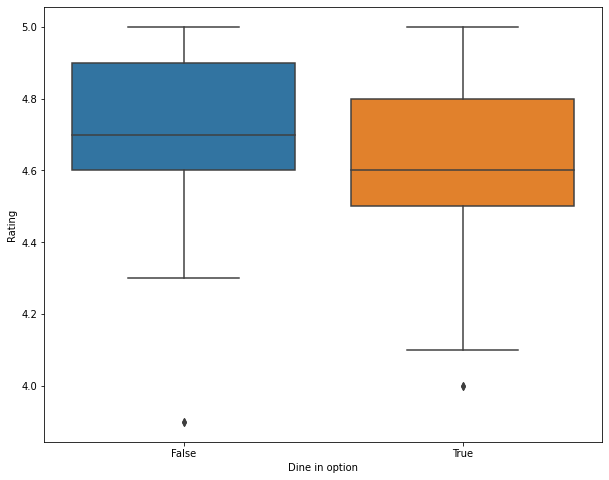

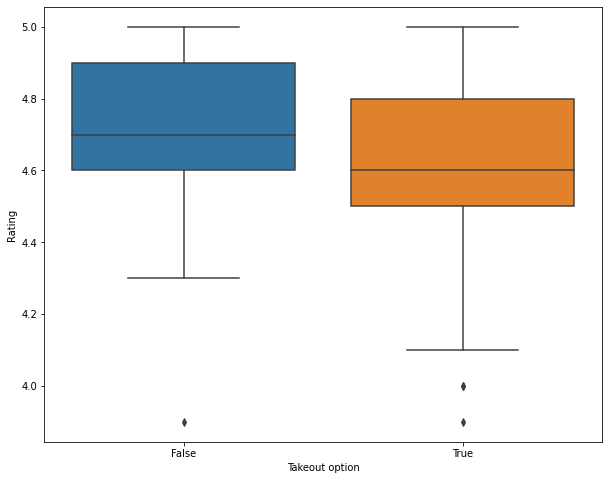

In [64]:
categorical_features = [feature for feature in df.columns if df[feature].dtype!='float' and 'Place name' not in feature]
types = ['Coffee shop', 'Cafe', 'Espresso bar', 'Coffee store']

for feature in categorical_features:
    plt.figure(figsize=(10, 8))
    dataset = df.copy()
    dataset['Place type'] = np.where(dataset['Place type'].isin(types), dataset['Place type'], 'Other')
    dataset[feature] = np.where(dataset[feature].isna(), 'Unknown', dataset[feature])
    sns.boxplot(x = feature, y = 'Rating', data = dataset)
    plt.xlabel(feature)
    plt.ylabel('Rating')
    plt.show()

Region: it seems that shops in Kiev and Odessa are better reviewed.

Place type: it seems that shops whose type is different from coffee store, coffee shop, espresso bar and cafes are better reviewed. Anyway, there are only 14 out of 200 shops in this category so the fact that they obtain a higher rating is not statistically reliable.

Price: it seems that shops whose price category is unknown are better reviewed.

Delivery option: it seems that shops whose delivery option is unknown are better reviewed.

Dine in option: it seems that shops which do not offer a dine-in option are better reviewed.

Takeout option: it seems that shops which do not offer a takeout option are better reviewed.

##### vs # of reviews

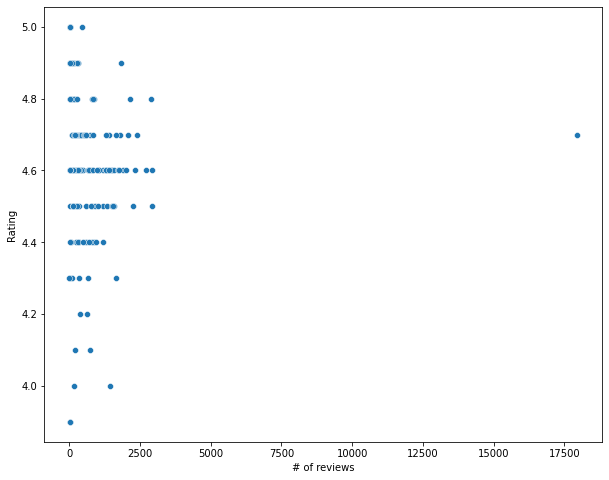

In [65]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Reviews', y='Rating', data = df)
plt.xlabel('# of reviews')
plt.ylabel('Rating')
plt.show()

It seems that shops with a higher number of reviews mostly receive ratings between 4.5 to 4.7.

#### # of Reviews (just for the purpose of not getting distorted plots, we will exclude a Lviv store that has more than 17500 reviews)

##### Distribution

<AxesSubplot:xlabel='Reviews', ylabel='Density'>

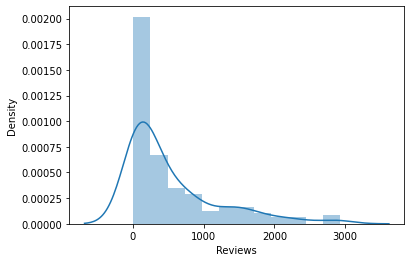

In [66]:
sns.distplot(df[df['Reviews']<17500]['Reviews'])

##### vs categorical features (we have already analyzed the relationship between rating and # of reviews)

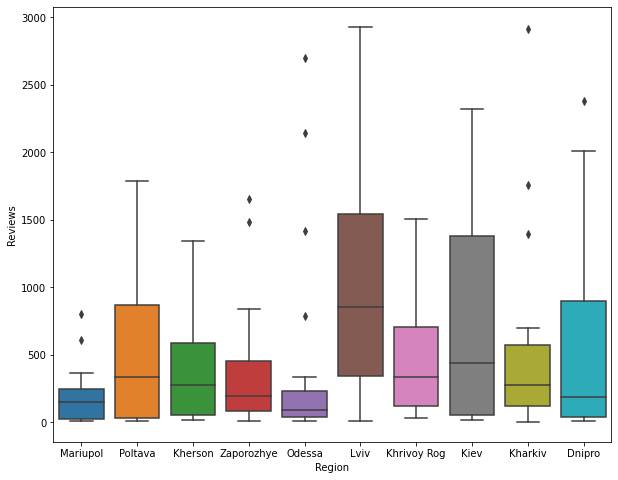

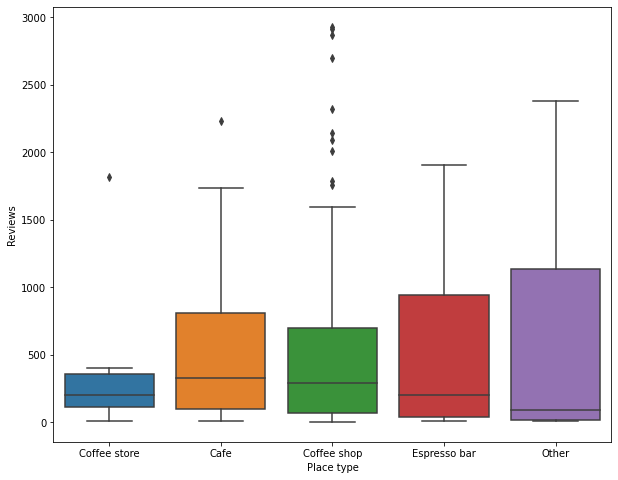

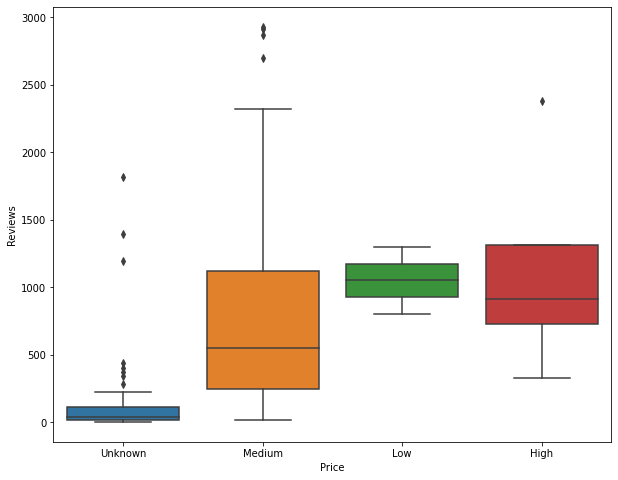

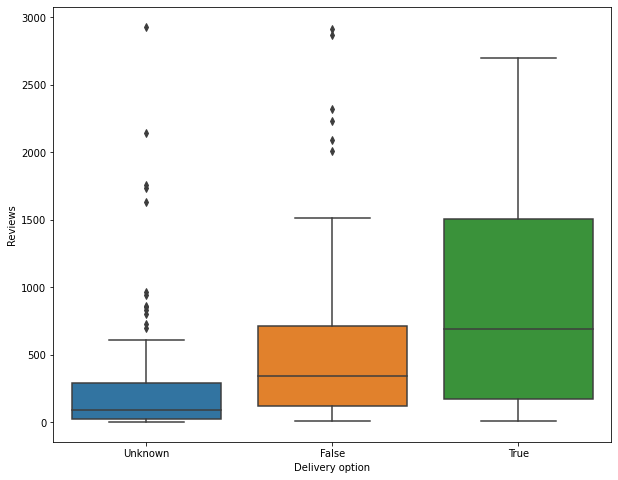

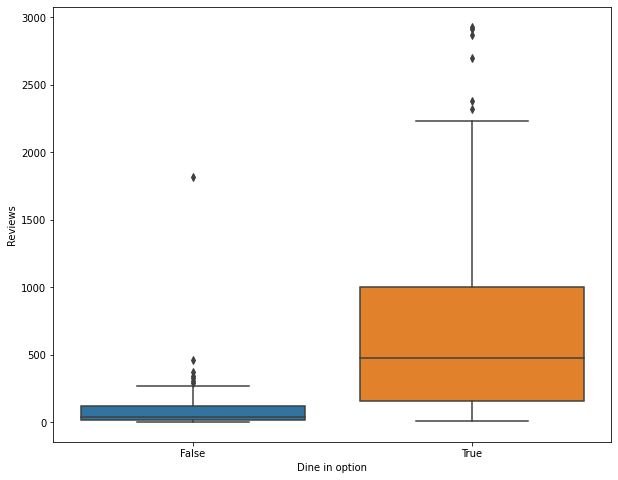

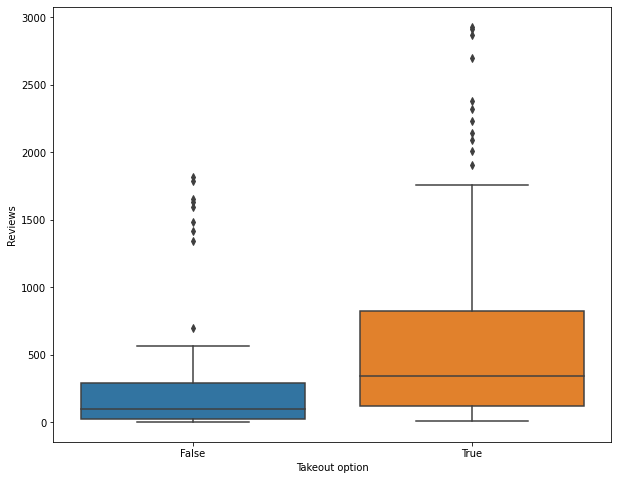

In [67]:
for feature in categorical_features:
    plt.figure(figsize=(10, 8))
    dataset = df[df['Reviews']<17500].copy()
    dataset['Place type'] = np.where(dataset['Place type'].isin(types), dataset['Place type'], 'Other')
    dataset[feature] = np.where(dataset[feature].isna(), 'Unknown', dataset[feature])
    sns.boxplot(x = feature, y = 'Reviews', data = dataset)
    plt.xlabel(feature)
    plt.ylabel('Reviews')
    plt.show()

Region: it seems that Lviv is the region where shops get a higher number of reviews.

Place type: there are no significant differences.

Price: it seems that shops with a 'high' or 'low' price category get a higher number of reviews than shops with a 'medium' price category. The least reviewed shops are those whose price category is unknown, so the fact that they get a higher rating (as evidenced by previous plots) is not statistically reliable.

Delivery option: it seems that shops offering a delivery option get a higher number of reviews than shops not offering it. Regarding shops whose delivery option is unknown, the same as above applies.

Dine in option: it seems that shops offering a dine-in option get a higher number of reviews than shops not offering it.

Takeout option: it seems that shops offering a takeout option get a higher number of reviews than shops not offering it.

### Categorical variables (vs other categorical features, we will not explore the 'categorical vs numerical' relationships again)

#### Place type

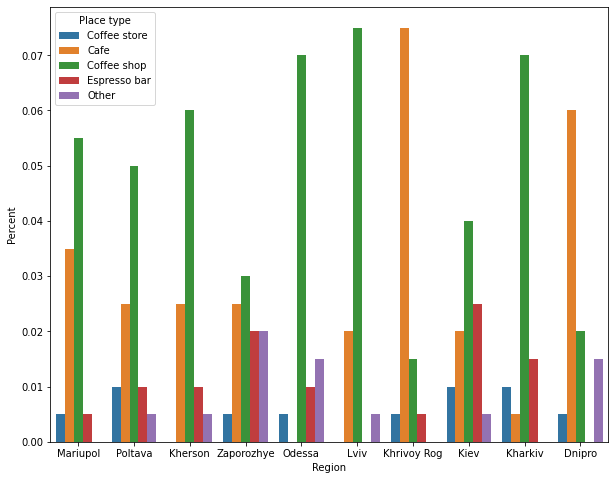

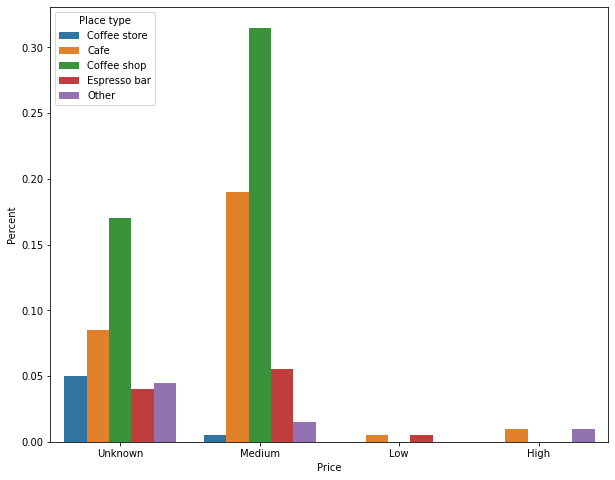

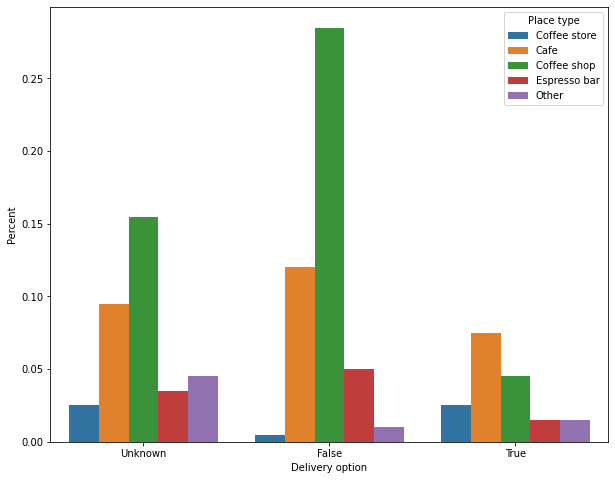

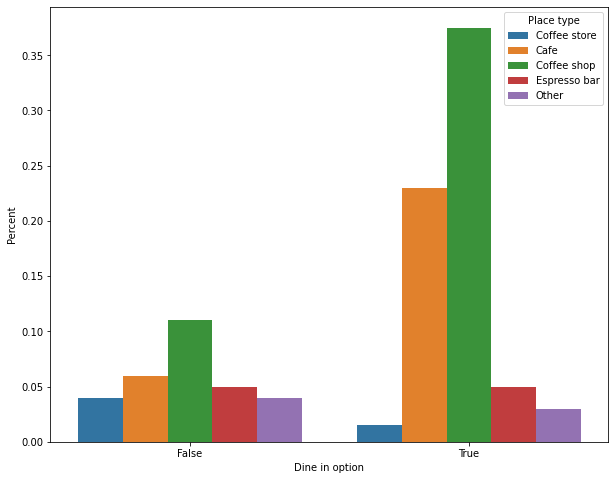

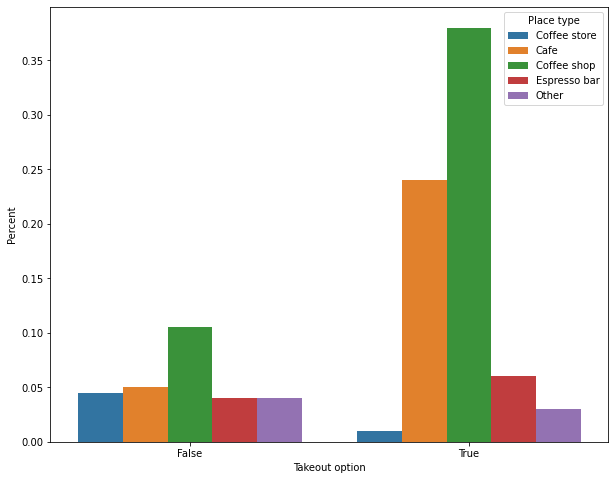

In [68]:
categorical_without_place_type = [feature for feature in df.columns if df[feature].dtype!='float' and 'Place name' not in feature and 'Place type' not in feature]

for i, feature in enumerate(categorical_without_place_type):
    dataset = df.copy()
    dataset['Place type'] = np.where(dataset['Place type'].isin(types), dataset['Place type'], 'Other')
    dataset[feature] = np.where(dataset[feature].isna(), 'Unknown', dataset[feature])
    dataset[feature+'_pct'] = dataset.groupby(['Place type', feature])[feature]\
                                   .transform(lambda x: len(x)) / len(dataset)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature, y=feature+'_pct', hue='Place type', data=dataset).set(xlabel=feature, ylabel='Percent')
    plt.show()

Region: Generally, coffee shops are the most popular shops, followed by cafes. Shops that fall under the 'other' category are the least popular.

Price: Generally, coffee shops and cafes present a 'medium' price category. Cafes and other shops are the only types of shops presenting 'high' price categories, while cafes and espresso bars are the only types of shops presenting 'low' price categories.

Delivery option: cafes are the type of shops which are more likely to offer the delivery option, while coffee shops in general do not offer it.

Dine in option: cafes and coffee shops generally offer the dine-in option, while the other shops type are almost equally divided.

Takeout option: same as above.

#### Price

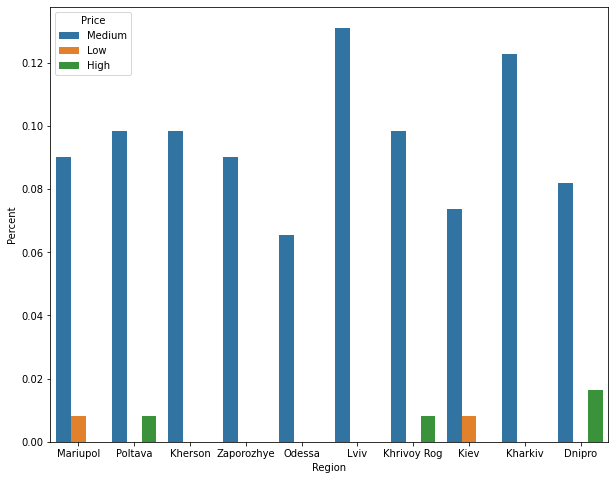

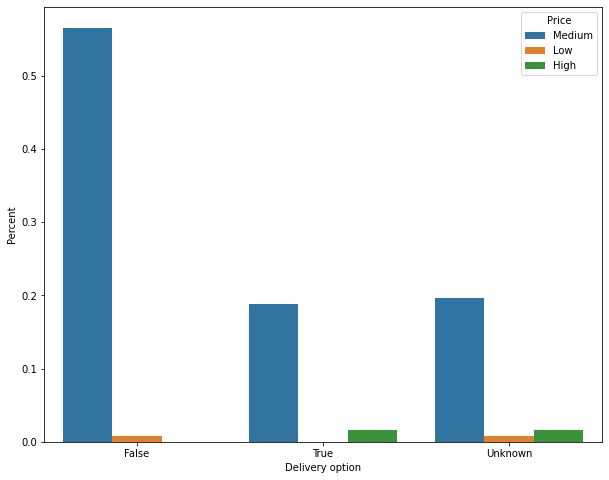

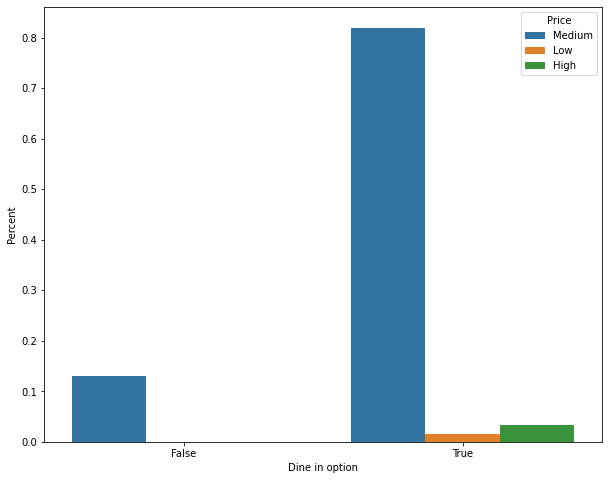

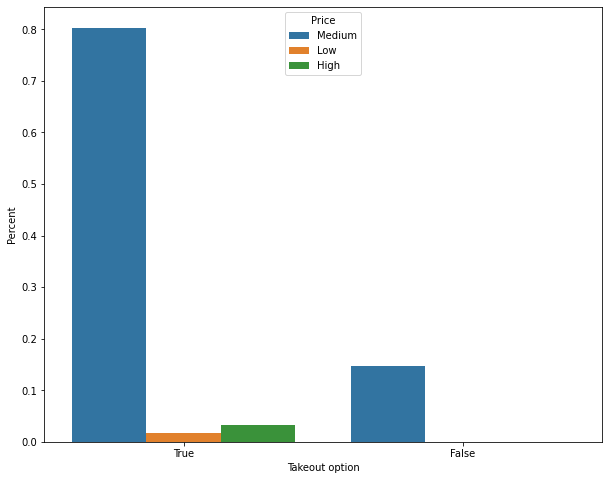

In [69]:
categorical_without_price = [feature for feature in df.columns if df[feature].dtype!='float' and 'Place name' not in feature and 'Place type' not in feature and 'Price' not in feature]

for i, feature in enumerate(categorical_without_price):
    dataset = df[df['Price'].notnull()].copy()
    dataset['Place type'] = np.where(dataset['Place type'].isin(types), dataset['Place type'], 'Other')
    dataset[feature] = np.where(dataset[feature].isna(), 'Unknown', dataset[feature])
    dataset[feature+'_pct'] = dataset.groupby(['Price', feature])[feature]\
                                   .transform(lambda x: len(x)) / len(dataset)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature, y=feature+'_pct', hue='Price', data=dataset).set(xlabel=feature, ylabel='Percent')
    plt.show()

Region: shops whose price category is 'high' are located only in Poltava, Khrivoy Rog and Dnipro. Shops whose price category is 'low' are located only in Mariupol and Kiev. All other shops have a 'medium' price category.

Delivery option: there is no shop whose price category is 'low' among those offering the delivery option. There is no shop whose price category is 'high' among those not offering the delivery option.

Dine in option: all of the shops whose price category is 'high' or 'low' offer the dine in option.

Takeout option: all of the shops whose price category is 'high' or 'low' offer the takeout in option.

#### Delivery option

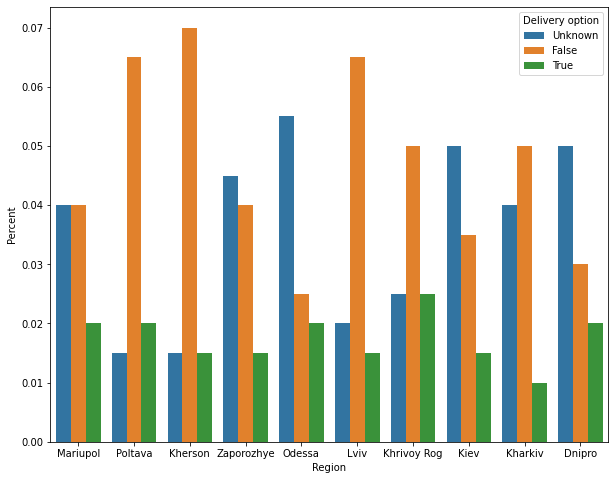

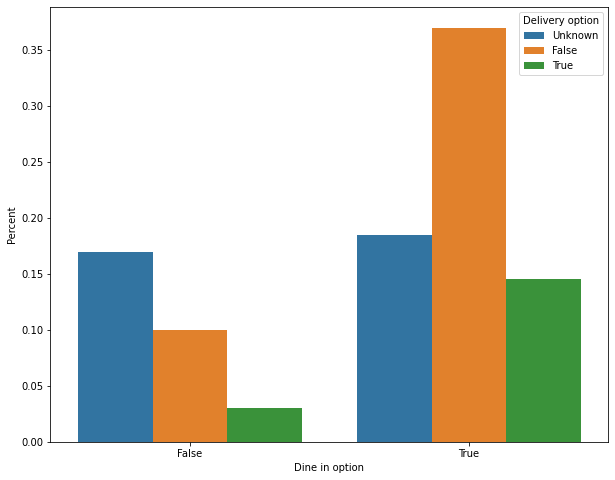

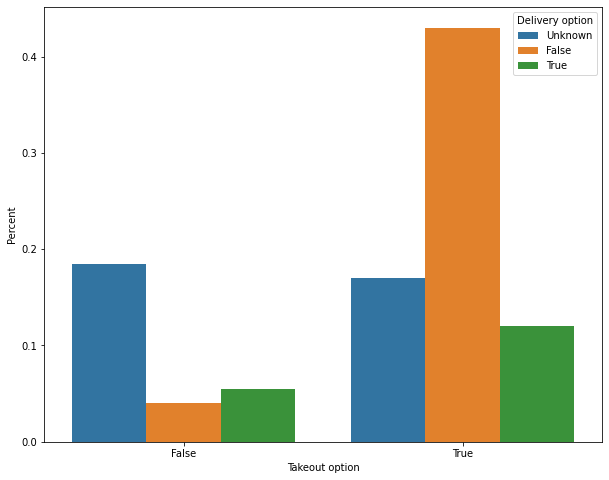

In [70]:
categorical_without_delivery = [feature for feature in df.columns if df[feature].dtype!='float' and 'Place name' not in feature and 'Place type' not in feature and 'Price' not in feature and 'Delivery option' not in feature]

for i, feature in enumerate(categorical_without_delivery):
    dataset = df.copy()
    dataset['Delivery option'] = np.where(dataset['Delivery option'].isna(), 'Unknown', dataset['Delivery option'])
    dataset['Place type'] = np.where(dataset['Place type'].isin(types), dataset['Place type'], 'Other')
    dataset[feature] = np.where(dataset[feature].isna(), 'Unknown', dataset[feature])
    dataset[feature+'_pct'] = dataset.groupby(['Delivery option', feature])[feature]\
                                   .transform(lambda x: len(x)) / len(dataset)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature, y=feature+'_pct', hue='Delivery option', data=dataset).set(xlabel=feature, ylabel='Percent')
    plt.show()

Region: Odessa and Dnipro are the regions with the higher proportion of shops offering a delivery option (over their relative totals). However, for the majority of the shops in each region the delivery option is not offered or unknown.

Dine in option: the majority of shops offering a dine-in option do not offer a delivery option, while for the majority of shops not offering the dine-in option, the delivery option is unknown.

Takeout option: the majority of shops offering a takeout option do not offer a delivery option, while for the majority of shops not offering the takeout option, the delivery option is unknown.

#### Dine in option

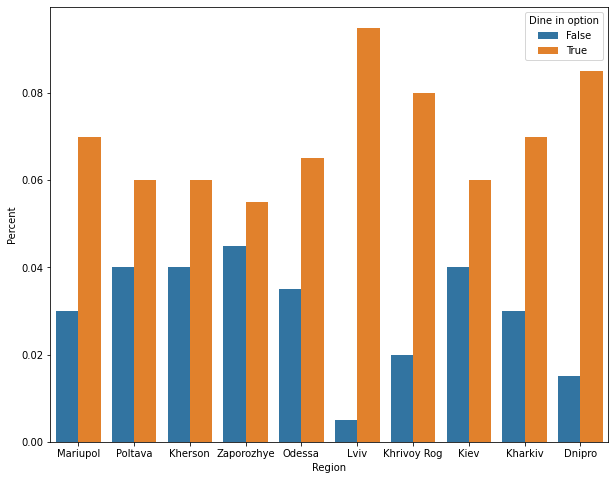

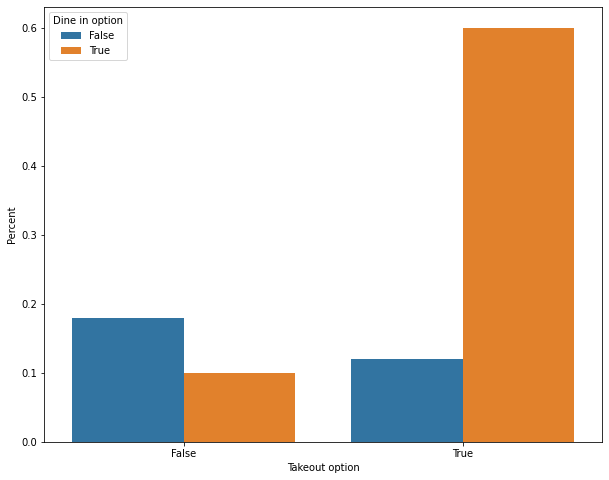

In [71]:
categorical_without_dinein = [feature for feature in df.columns if df[feature].dtype!='float' and 'Place name' not in feature and 'Place type' not in feature and 'Price' not in feature and 'Delivery option' not in feature and 'Dine in option' not in feature]

for i, feature in enumerate(categorical_without_dinein):
    dataset = df[df['Dine in option'].notnull()].copy()
    dataset['Place type'] = np.where(dataset['Place type'].isin(types), dataset['Place type'], 'Other')
    dataset[feature] = np.where(dataset[feature].isna(), 'Unknown', dataset[feature])
    dataset[feature+'_pct'] = dataset.groupby(['Dine in option', feature])[feature]\
                                   .transform(lambda x: len(x)) / len(dataset)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature, y=feature+'_pct', hue='Dine in option', data=dataset).set(xlabel=feature, ylabel='Percent')
    plt.show()

Region: almost every shop in Lviv, Dnipro and Khrivoy Rog offer a dine-in option.

Takeout option: shops that don't offer a take-out option are also more likely not to offer a dine-in option.

#### Takeout option

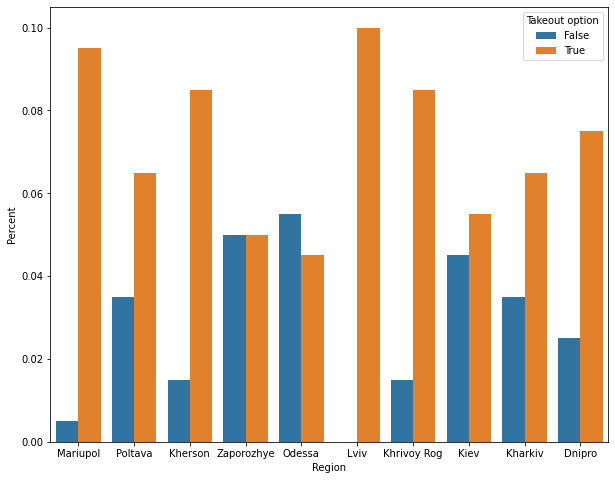

In [72]:
categorical_without_dinein = [feature for feature in df.columns if df[feature].dtype!='float' and 'Place name' not in feature and 'Place type' not in feature and 'Price' not in feature and 'Delivery option' not in feature and 'Dine in option' not in feature and 'Takeout option' not in feature]

for i, feature in enumerate(categorical_without_dinein):
    dataset = df[df['Takeout option'].notnull()].copy()
    dataset['Place type'] = np.where(dataset['Place type'].isin(types), dataset['Place type'], 'Other')
    dataset[feature] = np.where(dataset[feature].isna(), 'Unknown', dataset[feature])
    dataset[feature+'_pct'] = dataset.groupby(['Takeout option', feature])[feature]\
                                   .transform(lambda x: len(x)) / len(dataset)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature, y=feature+'_pct', hue='Takeout option', data=dataset).set(xlabel=feature, ylabel='Percent')
    plt.show()

Odessa, Zaporozhye and Kiev are the regions in which shops are less likely to offer a takeout option. Every shop in Lviv offers a takeout option.

## Feature engineering

### Handling missing values

#### Rating and Reviews

In [73]:
df[df['Rating'].isna()]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
49,Kherson,Кофе В Херсоне,Cafe,NaN,NaN,NaN,False,False,False
186,Dnipro,"Coffee&Cake, Game zone PS4",Coffee shop,NaN,NaN,NaN,NaN,False,False


We can proceed imputing the mean 'Rating' and 'Reviews' values for Cafes in Kherson to observation 49 and apply the same logic for observation 186.

In [74]:
rating_kherson_cafe = round(df[(df['Region'] == 'Kherson') & (df['Place type'] == 'Cafe')]['Rating'].mean(), 1)
df['Rating'] = np.where((df['Rating'].isnull()) & (df['Region']=='Kherson'), rating_kherson_cafe, df['Rating'])

reviews_kherson_cafe = round(df[(df['Region'] == 'Kherson') & (df['Place type'] == 'Cafe')]['Reviews'].mean(), 0)
df['Reviews'] = np.where((df['Reviews'].isnull()) & (df['Region']=='Kherson'), reviews_kherson_cafe, df['Reviews'])

rating_dnipro_coffeeshop = round(df[(df['Region'] == 'Dnipro') & (df['Place type'] == 'Coffee shop')]['Rating'].mean(), 1)
df['Rating'] = np.where((df['Rating'].isnull()) & (df['Region']=='Dnipro'), rating_dnipro_coffeeshop, df['Rating'])

reviews_dnipro_coffeeshop = round(df[(df['Region'] == 'Dnipro') & (df['Place type'] == 'Coffee shop')]['Reviews'].mean(), 0)
df['Reviews'] = np.where((df['Reviews'].isnull()) & (df['Region']=='Dnipro'), reviews_dnipro_coffeeshop, df['Reviews'])

df.isnull().sum()

Region              0
Place name          0
Place type          0
Rating              0
Reviews             0
Price              78
Delivery option    71
Dine in option      0
Takeout option      0
dtype: int64

#### Price and Delivery option

Here, we are dealing with categorical variables. Since the percentage of missing values for these two variables is between 30 to 40%, it is not the case to proceed imputing the mode. Still, we want to avoid losing information so we can't just drop the observations. We will replace missing values with the label 'Unknown', like we did in the EDA part.

In [75]:
df['Price'] = np.where(df['Price'].isna(), 'Unknown', df['Price'])
df['Delivery option'] = np.where(df['Delivery option'].isna(), 'Unknown', df['Delivery option'])

df.isnull().sum()

Region             0
Place name         0
Place type         0
Rating             0
Reviews            0
Price              0
Delivery option    0
Dine in option     0
Takeout option     0
dtype: int64

### Outliers treatment

During the EDA, we have noticed that there is one observation having an extremely high number of reviews. This can end up distorting the variable scaling process (and the clustering process as well), so we need to take care of it properly.

In [76]:
df[df['Reviews']>17500]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
100,Lviv,Lviv Coffee Manufacture,Coffee shop,4.7,17937.0,Medium,True,True,True


Once again, to avoid losing information, we will impute this outlier with the 99.5 percentile (which is still way lower).

In [77]:
df.iloc[100, 4] = round(np.percentile(df['Reviews'], 99.5),0)

In [78]:
df.iloc[100]

Region                                Lviv
Place name         Lviv Coffee Manufacture
Place type                     Coffee shop
Rating                                 4.7
Reviews                             3006.0
Price                               Medium
Delivery option                       True
Dine in option                        True
Takeout option                        True
Name: 100, dtype: object

### Encoding categorical variables

Here, we are dealing with nominal categorical variables (therefore, we cannot perform neither label encoding, nor target-guided label encoding).

The choice is narrowed to either one-hot encoding or mean-encoding. By the way, since we are dealing with a clustering problem (and we do not have any target variable), the only type of encoding we can perform is one-hot encoding. That is a good choice also because the number of variables present in the dataset is limited.

The only two variables we won't use for clustering are "Region" (the marketing manager wants to identify Ukrainian key coffee shop segments regardless of the location region) and "Place name" (it doesn't provide any useful information in that sense).

#### Splitting the dataset between numerical and categorical variables

In [29]:
numerical = [feature for feature in df.columns if df[feature].dtype=='float']
categorical = ['Place type', 'Price', 'Delivery option', 'Dine in option', 'Takeout option']

num_df = df[numerical]

cat_df = df[categorical]
cat_df['Dine in option'] = cat_df['Dine in option'].astype('O')
cat_df['Takeout option'] = cat_df['Takeout option'].astype('O')
cat_df = pd.get_dummies(cat_df, drop_first=True)

We had to convert boolean variables ('Dine in Option' and 'Takeout option') before proceeding with encoding.

#### Merging the datasets back together

In [30]:
encoded = pd.concat([num_df, cat_df], axis=1)

encoded

,Rating,Reviews,Place type_Cafe,Place type_Chocolate shop,Place type_Coffee roasters,Place type_Coffee shop,Place type_Coffee stand,Place type_Coffee store,Place type_E-commerce service,Place type_Espresso bar,...,Place type_Pastry shop,Place type_Restaurant,Place type_Store,Price_Low,Price_Medium,Price_Unknown,Delivery option_True,Delivery option_Unknown,Dine in option_True,Takeout option_True
0,4.6,206.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,5.0,24.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,5.0,11.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3,4.4,331.0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
4,5.0,12.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,4.6,963.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,1
196,4.3,646.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
197,4.6,16.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
198,4.7,599.0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,1,1


### Scaling

Since our variables are expressed in different units of measure, we must scale them so as to avoid that they can be assigned different weights during clustering. We will use MinMaxScaler.

In [31]:
scaler = MinMaxScaler()

scaler.fit(encoded)

encoded_columns = encoded.columns

scaled = pd.DataFrame(scaler.transform(encoded), columns=encoded_columns)

In [32]:
scaled

,Rating,Reviews,Place type_Cafe,Place type_Chocolate shop,Place type_Coffee roasters,Place type_Coffee shop,Place type_Coffee stand,Place type_Coffee store,Place type_E-commerce service,Place type_Espresso bar,...,Place type_Pastry shop,Place type_Restaurant,Place type_Store,Price_Low,Price_Medium,Price_Unknown,Delivery option_True,Delivery option_Unknown,Dine in option_True,Takeout option_True
0,0.636364,0.067598,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.000000,0.006993,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.002664,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.454545,0.109223,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,1.000000,0.002997,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.636364,0.319677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
196,0.363636,0.214117,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
197,0.636364,0.004329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
198,0.727273,0.198466,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0


## Clustering

As can be seen below, the dendrogram (from hierarchical clustering) suggests that the ideal number of clusters could alternatively be 4 or 6.

The elbow method plot, instead, suggests that the ideal number of clusters could alternatively be 4 or 5.

Therefore, the number of clusters chosen is 4. Furthermore, it can be observed that the clusters assigned by the two algorithms coincide almost perfectly. Consequently, we are going to give a unique interpretation of the clusters built by taking the results of hierarchical clustering as point of reference.

#### Hierarchical Clustering

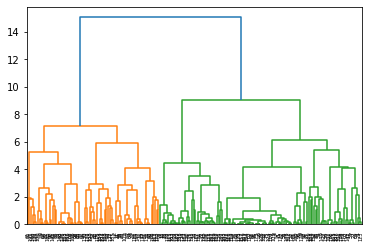

In [33]:
Z = linkage(scaled,
            method='ward',
            metric='euclidean')
dn = dendrogram(Z)
plt.show()

In [34]:
df['cluster_labels'] = fcluster(Z, 4, criterion='maxclust')

#### K-means clustering

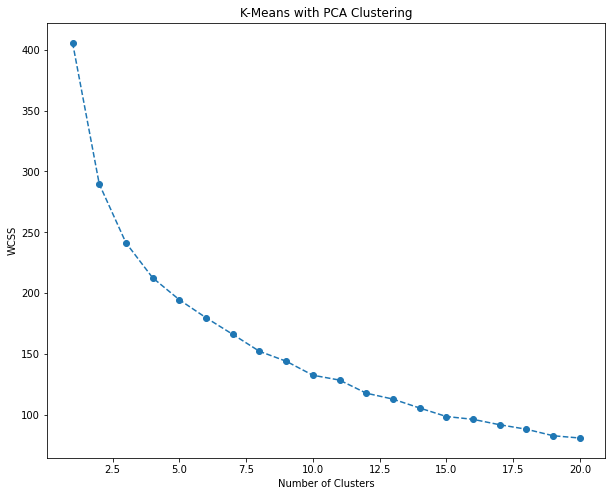

In [35]:
WCSS = []

for i in range(1,21):
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state=42)
    kmeans.fit(scaled)
    WCSS.append(kmeans.inertia_)
                      

plt.figure(figsize=(10,8))
plt.plot(range(1,21), WCSS, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-Means with PCA Clustering')
plt.show()

In [36]:
kmeans = KMeans(n_clusters = 4, init='k-means++', random_state=42)

kmeans.fit(scaled)

df['kmeans_labels'] = kmeans.labels_

#### Clusters interpretation

In [37]:
df.groupby('cluster_labels')['Region'].count()

cluster_labels
1    34
2    45
3    38
4    83
Name: Region, dtype: int64

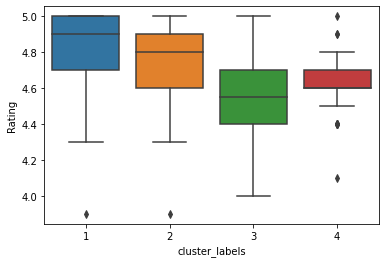

In [38]:
sns.boxplot(x= 'cluster_labels', y = 'Rating', data = df)
plt.show()

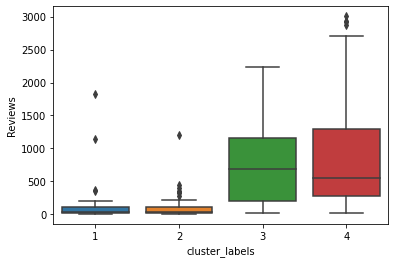

In [39]:
sns.boxplot(x= 'cluster_labels', y = 'Reviews', data = df)
plt.show()

In [40]:
df.groupby(['cluster_labels', 'Place type'])['Place name'].count()

cluster_labels  Place type              
1               Appliance repair service     1
                Coffee roasters              1
                Coffee shop                 16
                Coffee store                 9
                E-commerce service           1
                Espresso bar                 2
                Internet shop                1
                Store                        3
2               Cafe                        18
                Coffee roasters              1
                Coffee shop                 18
                Coffee store                 2
                Espresso bar                 5
                Pastry shop                  1
3               Cafe                        37
                Restaurant                   1
4               Cafe                         3
                Chocolate shop               1
                Coffee shop                 63
                Coffee stand                 1
                Esp

In [41]:
df.groupby(['cluster_labels', 'Price'])['Place name'].count()

cluster_labels  Price  
1               Medium      1
                Unknown    33
2               High        1
                Unknown    44
3               High        2
                Low         1
                Medium     35
4               High        1
                Low         1
                Medium     80
                Unknown     1
Name: Place name, dtype: int64

In [42]:
df.groupby(['cluster_labels', 'Delivery option'])['Place name'].count()

cluster_labels  Delivery option
1               False               2
                True                6
                Unknown            26
2               False              22
                True                5
                Unknown            18
3               False              14
                True               11
                Unknown            13
4               False              56
                True               13
                Unknown            14
Name: Place name, dtype: int64

In [43]:
df.groupby(['cluster_labels', 'Dine in option'])['Place name'].count()

cluster_labels  Dine in option
1               False             27
                True               7
2               False             18
                True              27
3               False              1
                True              37
4               False             14
                True              69
Name: Place name, dtype: int64

In [44]:
df.groupby(['cluster_labels', 'Takeout option'])['Place name'].count()

cluster_labels  Takeout option
1               False             34
2               False              5
                True              40
3               False              5
                True              33
4               False             12
                True              71
Name: Place name, dtype: int64

Cluster 1 (n=34): highest ratings, very low number of reviews, mainly coffee shops or coffee stores whose price category is unknown. Their delivery option is mainly unknown (even if there are some shops offering it). Almost 80% of them do not offer the dine-in option, while the remaining 20% do so. No one of them offers the takeout option.

Cluster 2 (n=45): higher ratings, lowest number of reviews, mainly cafes or coffee shops whose price category is unknown. The delivery option is either unknown or not offered. Exactly 80% of them do offer the dine-in option, while 20% of them do not. About 88% of them offer the takeout option.

Cluster 3 (n=38): lowest ratings, very high number of reviews, mainly cafes having a 'medium' price category. The delivery option is almost equally distributed between offered, not offered and unknown. Almost every of them offers the dine-in option. About 87% of them offer the takeout option.

Cluster 4 (n=83): lower ratings, highest number of reviews, mainly coffee shops and espresso bars having a 'medium' price category. The delivery option is mainly not offered. The vast majority of them offers the dine-in option. About 86% of them offer the takeout option.

### Insights

#### Business interpretations

The Ukrainian coffee market shows good potential from a business expansion perspective and is divided as follows:

Newly-opened likely deliverers (1): these are shops that are not very well known (very low number of reviews) but are loved by their customers (highest ratings, on average). There is not enough information on their price range or whether they deliver coffee or not, but since they do not offer the dine in and takeout options, and being mostly coffee shops and coffee stores, it can be assumed that they are newly opened shops that actually carry out the delivery service.

Newly-opened coffee servers (2): these are shops that are poorly known (lowest number of reviews) but are highly appreciated by their customers (high ratings, on average). There is not enough information on their price range or whether they deliver coffee or not (some of them definitely do not), but since most of them offer the dine in and takeout options, and being mostly cafes or coffee shops, it can be assumed that they are newly opened shops mainly focused on serving the coffee on site rather than delivering it.

Well-established cafes which also deliver (3): these are shops that are very well known (very high number of reviews) but are less appreciated by their customers if compared to first 2 competitors (lowest ratings, on average). Their price category is 'medium'. They either serve or deliver coffee and offer the dine-in and takeout options as well, mainly being cafes that have tried to benefit from recent market dynamics.

Well-established traditional bars and shops (4): these are very famous shops (highest number of reviews) but are less appreciated by their customers if compared to first 2 competitors (low ratings, on average). Their price category is 'medium'. They do not offer the delivery option, while they do offer the dine-in and takeout options, being traditional bars and shops which haven't tried to expand through delivery.

#### Suggestions

Some shops have recently started trying to fill the Ukrainian coffee delivery segment. Furthermore, judging by the appreciation received, it would appear that they are doing well and that Ukrainians are ready for this type of buying approach. The development possibilities for our company, in case of expansion in this geographic market, are concrete but not free from risks. It was also noted that the delivery shops are mainly located in Odessa, Kiev and Zaporozhye.

In [55]:
df[df['cluster_labels']==1].groupby(['cluster_labels', 'Region'])['Place name'].count().sort_values(ascending=False)

cluster_labels  Region    
1               Odessa        9
                Kiev          7
                Zaporozhye    6
                Poltava       4
                Dnipro        3
                Kharkiv       3
                Kherson       1
                Mariupol      1
Name: Place name, dtype: int64

It is therefore recommended to:
1. On the one hand, it could be convenient to enter the Ukrainian coffee market by focusing on the locations where the deliverers are not yet present, so as to postpone the competition over time until eventually we want to expand further on Ukrainian soil (although it would be useful to know their delivery range as it is not certain that they operate only locally). On the other hand, it could be that where the deliverers are not yet present, there is no target clientele ready for this purchasing approach (and even in this case it would be useful to collect further information)
2. Collect more complete information in order to clarify the doubts that have emerged, but also to understand the market positioning of the shops in the critical cluster (e.g. being able to know their price range).
2. With more information available, the analysis can be refined and thus become an even more solid support for the decision to enter the Ukrainian coffee market (and how) or not.